In [1]:
import pandas as pd
import numpy as np

from scipy.stats import mode

from collections import deque

import utils as u

import pickle
import time

import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

from scipy.stats import entropy

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support

from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin
from sklearn.pipeline import FeatureUnion
from imblearn.pipeline import Pipeline

# vectorizers
from sklearn.feature_extraction.text import TfidfVectorizer

# feature selectors
from sklearn.feature_selection import SelectKBest, chi2

# scalers
from sklearn.preprocessing import MinMaxScaler

# classifiers
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import ComplementNB
from sklearn.linear_model import LogisticRegression

# samplers
from imblearn.under_sampling import TomekLinks

# calibration
from sklearn.calibration import CalibratedClassifierCV

In [2]:
df = pd.read_pickle('../pandas/lemma_delivered_merged_df.pkl')

In [3]:
#df['ft'] = pd.read_pickle('../pandas/FT_TFIDF_lemma_labeled_vocab.pkl')
df['ft'] = pd.read_pickle('../pandas/FT_TFIDF_lemma_full_vocab.pkl')
df['is_nn'] = pd.read_pickle('../pandas/is_nn_full.pkl')
df['is_trash'] = pd.read_pickle('../pandas/is_trash_full.pkl')

In [4]:
labeled_corpus = df[(df['agg_label'] != -1) & (df['is_nn'] == False)]
unlabeled_corpus = df[(df['agg_label'] == -1) & (df['is_nn'] == False) & (df['is_trash'] == False)]

target = 'agg_label'
text = 'lemma_delivered'
fasttext = 'ft'
numeric = ['raw_len', 'raw_word_count']

In [5]:
train_X, vali_X, train_y, vali_y = train_test_split(
    labeled_corpus,
    labeled_corpus[target],
    test_size=0.4,
    random_state=1,
    stratify=labeled_corpus[target])

test_X, validation_X, test_y, validation_y = train_test_split(
    vali_X,
    vali_y,
    test_size=0.5,
    random_state=1,
    stratify=vali_y)

In [6]:
# models
clf_LinearSVC = LinearSVC(**{'C': 0.5, 'loss': 'squared_hinge', 'tol': 0.01})
baseline_model = {
    'title': 'baseline_model',
    'features': ('Text+FT', {'text': text, 'ft': fasttext}),
    'vectorizer': ('TfidfVectorizer', TfidfVectorizer, {'lowercase': False, 'max_df': 0.25}),
    'scaler': ('MinMaxScaler', MinMaxScaler, {'feature_range': (0,1)}),
    'sampler': ('TomekLinks', TomekLinks, {'random_state': 1, 'sampling_strategy': 'majority', 'n_jobs': -1}),
    #'sampler': ('No_sampling', u.PassThrough, {}),
    'classifier': ('CalibratedClassifierCV_LinearSVC', CalibratedClassifierCV, {'base_estimator': clf_LinearSVC, 'method': 'isotonic', 'cv': 3}),
    #'classifier': ('LinearSVC', LinearSVC, {'C': 0.5, 'loss': 'squared_hinge', 'tol': 0.01}),
}

quick_svm_model = {
    'title': 'quick_svm_model',
    'features': ('Text+FT', {'text': text}),
    'vectorizer': ('TfidfVectorizer', TfidfVectorizer, {'lowercase': False, 'max_df': 0.25}),
    'scaler': ('No_scaling', u.PassThrough, {}),
    'sampler': ('No_sampling', u.PassThrough, {}),
    'classifier': ('LinearSVC', LinearSVC, {'C': 0.5, 'loss': 'squared_hinge', 'tol': 0.01}),
}

clf_ComplementNB = ComplementNB(**{'alpha': 0.2})
quick_model = {
    'title': 'quick_model',
    'features': ('TextOnly', {'text': text}),
    'vectorizer': ('TfidfVectorizer', TfidfVectorizer, {'lowercase': False, 'max_df': 0.25}),
    'scaler': ('No_scaling', u.PassThrough, {}),
    'sampler': ('No_sampling', u.PassThrough, {}),
    'classifier': ('CalibratedClassifierCV_ComplementNB', CalibratedClassifierCV, {'base_estimator': clf_ComplementNB, 'method': 'isotonic', 'cv': 3}),
    #'classifier': ('CalibratedClassifierCV_ComplementNB', CalibratedClassifierCV, {'base_estimator': clf_ComplementNB, 'cv': 3}),
}

clf_LogisticRegression = LogisticRegression(**{'solver': 'saga', 'tol': 0.0001, 'C': 8, 'n_jobs': -1, 'random_state': 1})
log_model = {
    'title': 'log_model',
    'features': ('TextOnly', {'text': text}),
    'vectorizer': ('TfidfVectorizer', TfidfVectorizer, {'lowercase': False, 'max_df': 0.25}),
    'scaler': ('No_scaling', u.PassThrough, {}),
    'sampler': ('No_sampling', u.PassThrough, {}),
    'classifier': ('CalibratedClassifierCV_LogisticRegression', CalibratedClassifierCV, {'base_estimator': clf_LogisticRegression, 'method': 'isotonic', 'cv': 3}),
}

wordembed_model = {
    'title': 'wordembed_model',
    'features': ('FT', {'ft': fasttext}),
    'vectorizer': ('TfidfVectorizer', u.PassThrough, {}),
    'scaler': ('MinMaxScaler', MinMaxScaler, {'feature_range': (0,1)}),
    #'sampler': ('TomekLinks', TomekLinks, {'random_state': 1, 'sampling_strategy': 'majority', 'n_jobs': -1}),
    'sampler': ('No_sampling', u.PassThrough, {}),
    'classifier': ('CalibratedClassifierCV_LinearSVC', CalibratedClassifierCV, {'base_estimator': clf_LinearSVC, 'method': 'isotonic', 'cv': 3}),
    #'classifier': ('LinearSVC', LinearSVC, {'C': 0.5, 'loss': 'squared_hinge', 'tol': 0.01}),
}

In [55]:
class FastTextSelector(BaseEstimator, TransformerMixin):
    def __init__(self, col):
        self.col = col

    def fit(self, df, y=None):
        return self

    def transform(self, df):
        return np.stack(df[self.col].to_numpy())

def modeller(data, model):

    features = []

    if 'text' in model['features'][1]:
        features.append(
            ('text', Pipeline([
                ('article', u.ColumnSelector(model['features'][1]['text'])),
                ('vectorizer', model['vectorizer'][1](**model['vectorizer'][2])),
            ]))
        )

    if 'ft' in model['features'][1]:
        features.append(
            ('embeddings', Pipeline([
                ('ft', FastTextSelector(model['features'][1]['ft'])),
                ('scaler', model['scaler'][1](**model['scaler'][2])),
            ]))
        )

    model = Pipeline([
        ('features', FeatureUnion(features)),
        ('sampler', model['sampler'][1](**model['sampler'][2])),
        ('classifier', model['classifier'][1](**model['classifier'][2]))
    ])
    

    model.fit(data['train_X'], data['train_y'])
    preds = model.predict(data['validation_X'])
    probs = model.predict_proba(data['validation_X'])
    
    metrics = {}
    
    if 'validation_y' in data:
        metrics['acc'] = accuracy_score(data['validation_y'], preds)
        metrics['prec'], metrics['reca'], metrics['fsco'], _ = precision_recall_fscore_support(data['validation_y'], preds, average='macro')
        #print(acc, prec, reca, fsco)
    
    return preds, probs, metrics, model['classifier'].classes_

def get_entropy_train_x(t_X, t_y, scaler):
    
    train_a_X, train_b_X, train_a_y, train_b_y = train_test_split(
        t_X,
        t_y,
        test_size=0.5,
        random_state=1,
        stratify=t_y)
    
    data_a = {
        'train_X': train_a_X,
        'train_y': train_a_y,
        'validation_X': train_b_X,
        'validation_y': train_b_y
    }
    
    data_b = {
        'train_X': train_b_X,
        'train_y': train_b_y,
        'validation_X': train_a_X,
        'validation_y': train_a_y
    }
    
    preds_b, probs_b, metric_b = modeller(data_a, baseline_model)
    preds_a, probs_a, metric_a = modeller(data_b, baseline_model)

    prob_a = np.amax(probs_a, axis=1)
    prob_b = np.amax(probs_b, axis=1)

    dynamic_threshold = get_dynamic_threshold(preds_b, prob_b, scaler)
    #dynamic_thresholds_b = get_dynamic_threshold(preds_a, prob_a, scaler)
    
    print(dynamic_threshold)

    entropy_a = entropy(probs_a.T)
    entropy_b = entropy(probs_b.T)
    
    entropy_ab = np.concatenate([entropy_a, entropy_b])
    
    mean_entropy = entropy_ab.mean() + ((entropy_ab.max() - entropy_ab.mean())/2)

    mask_below_a = entropy_a <= mean_entropy
    mask_below_b = entropy_b <= mean_entropy
    
    mask_above_a = entropy_a > mean_entropy
    mask_above_b = entropy_b > mean_entropy
    
    index_below = train_a_X.loc[mask_below_a].index.union(train_b_X.loc[mask_below_b].index)
    index_above = train_a_X.loc[mask_above_a].index.union(train_b_X.loc[mask_above_b].index)

    #probs_a_sorted = np.sort(probs_a)
    #probs_b_sorted = np.sort(probs_b)
    #margin_a = 1 - (probs_a_sorted[:,-1] + probs_a_sorted[:,-2])
    #margin_b = 1 - (probs_b_sorted[:,-1] + probs_b_sorted[:,-2])
    #margin = np.concatenate([margin_a, margin_b])

    return index_below, index_above, dynamic_threshold


def get_entropy_co_trained(data, index_below, index_above, dynamic_threshold, threshold=0.9, scaler=0.93):

    data_a = {
        'train_X': data['train_X'].loc[index_below],
        'train_y': data['train_y'].loc[index_below],
        'validation_X': data['validation_X']
    }

    data_b = {
        'train_X': data['train_X'].loc[index_above],
        'train_y': data['train_y'].loc[index_above],
        'validation_X': data['validation_X']
    }

    preds_a, probs_a, _ = modeller(data_a, baseline_model)
    preds_b, probs_b, _ = modeller(data_b, baseline_model)
    
    #dynamic_threshold_a = get_dynamic_threshold(preds_b, np.amax(probs_a, axis=1), scaler)
    #dynamic_threshold_b = get_dynamic_threshold(preds_b, np.amax(probs_b, axis=1), scaler)
    #print(dynamic_threshold_a)
    #print(dynamic_threshold_b)
    
    print("Mean entropy a: " + str(entropy(probs_a.T).mean()))
    print("Mean entropy b: " + str(entropy(probs_b.T).mean()))
    
    print("Mean probs a: " + str(np.amax(probs_a, axis=1).mean()) + ", Max probs a: " + str(np.amax(probs_a, axis=1).max()))
    print("Mean probs b: " + str(np.amax(probs_b, axis=1).mean()) + ", Max probs b: " + str(np.amax(probs_b, axis=1).max()))
    
    pred_mask = preds_a == preds_b
    
    print("Number of equals: " + str(pred_mask.sum()))
    
    prob_mask_a = np.amax(probs_a, axis=1) > threshold
    prob_mask_b = np.amax(probs_b, axis=1) > threshold
    
    #prob_mask_a = get_dynamic_threshold_mask(preds_a, np.amax(probs_a, axis=1), dynamic_threshold)
    #prob_mask_b = get_dynamic_threshold_mask(preds_b, np.amax(probs_b, axis=1), dynamic_threshold)
    
    print("Prob mask a: " + str(prob_mask_a.sum()))
    print("Prob mask b: " + str(prob_mask_b.sum()))
    
    prob_mask = np.all(np.array([prob_mask_a, prob_mask_b]), axis=0)
    
    mask = np.all(np.array([pred_mask, prob_mask]), axis=0)
    
    print("Mask length: " + str(mask.sum()))
    
    return mask, preds_a


def get_dynamic_threshold(preds, probs, scaler=0.9):
    
    dynamic_thresholds = {}
    for l in np.unique(preds):
        if l in [12]:
            dynamic_thresholds[l] = probs[preds == l].max() * (scaler + 0.15)
        elif l in [15, 16, 20, 3]:
            dynamic_thresholds[l] = probs[preds == l].max() * (scaler + 0.10)
        elif l in [10, 17, 19]:
            dynamic_thresholds[l] = probs[preds == l].max() * (scaler + 0.05)
        else:
            dynamic_thresholds[l] = probs[preds == l].max() * scaler
            
            
        '''elif l in [15, 16, 20, 3]:
            dynamic_thresholds[l] = probs[preds == l].max() * (scaler + 0.05)
        elif l in [10, 17, 19]:
            dynamic_thresholds[l] = probs[preds == l].max() * (scaler + 0.05)'''
            
            
        '''elif l in [10]:
            dynamic_thresholds[l] = probs[preds == l].max() * (scaler + 0.15)
        elif l in [6,8,20]:
            dynamic_thresholds[l] = probs[preds == l].max() * (scaler + 0.14)'''     
            
        
        #dynamic_thresholds[l] = probs[preds == l].max() * scaler
        
    return dynamic_thresholds

def get_dynamic_threshold_mask(preds, probs, dynamic_thresholds):
        
    mask = []
    for i in range(preds.shape[0]):
        if probs[i] >= dynamic_thresholds[preds[i]]:
            mask.append(True)
        else:
            mask.append(False)
    
    return np.array(mask)


def get_model(data, scaler=0.9):

    preds, probs, _, _ = modeller(data, baseline_model)

    prob = np.amax(probs, axis=1)
    
    dynamic_threshold = get_dynamic_threshold(preds, prob, scaler)
    
    mask = get_dynamic_threshold_mask(preds, prob, dynamic_threshold)
    
    return mask, preds


def random_split(data, scaler=0.9, threshold=0.9):
    
    train_a_X, train_b_X, train_a_y, train_b_y = train_test_split(
        data['train_X'],
        data['train_y'],
        test_size=0.5,
        random_state=1,
        stratify=data['train_y'])
    
    data_a = {
        'train_X': train_a_X,
        'train_y': train_a_y,
        'validation_X': data['validation_X']
    }

    data_b = {
        'train_X': train_b_X,
        'train_y': train_b_y,
        'validation_X': data['validation_X']
    }

    preds_a, probs_a, _ = modeller(data_b, baseline_model)
    preds_b, probs_b, _ = modeller(data_a, baseline_model)

    prob_a = np.amax(probs_a, axis=1)
    prob_b = np.amax(probs_b, axis=1)

    dynamic_threshold = get_dynamic_threshold(preds_b, prob_b, scaler)

    print(dynamic_threshold)

    pred_mask = preds_a == preds_b

    #prob_mask_a = get_dynamic_threshold_mask(preds_a, np.amax(probs_a, axis=1), dynamic_threshold)
    #prob_mask_b = get_dynamic_threshold_mask(preds_b, np.amax(probs_b, axis=1), dynamic_threshold)
    
    prob_mask_a = np.amax(probs_a, axis=1) > threshold
    prob_mask_b = np.amax(probs_b, axis=1) > threshold

    print("Prob mask a: " + str(prob_mask_a.sum()))
    print("Prob mask b: " + str(prob_mask_b.sum()))

    prob_mask = np.all(np.array([prob_mask_a, prob_mask_b]), axis=0)

    mask = np.all(np.array([pred_mask, prob_mask]), axis=0)

    print("Mask length: " + str(mask.sum()))

    return mask, preds_a


def support_vector_split(data, scaler=0.9, threshold=0.9):
    
    vec = TfidfVectorizer(**{'lowercase': False, 'max_df': 0.25})
    vec_t_X = vec.fit_transform(data['train_X'][text])
    clf = LinearSVC(**{'C': 0.5, 'loss': 'squared_hinge', 'tol': 0.01}).fit(vec_t_X, data['train_y'])
    decision_function = clf.decision_function(vec_t_X)
    support_vector_indices = np.where(np.amin(np.abs(decision_function), axis=1) <= 0.4)[0]
    not_support_vector_indices = [x for x in range(X.shape[0]) if x not in support_vector_indices]
    
    #display(data['train_y'].iloc[support_vector_indices].value_counts())
    #display(data['train_y'].iloc[not_support_vector_indices].value_counts())

    data_a = {
        'train_X': data['train_X'].iloc[support_vector_indices],
        'train_y': data['train_y'].iloc[support_vector_indices],
        'validation_X': data['validation_X']
    }

    data_b = {
        'train_X': data['train_X'].iloc[not_support_vector_indices],
        'train_y': data['train_y'].iloc[not_support_vector_indices],
        'validation_X': data['validation_X']
    }

    preds_a, probs_a, _ = modeller(data_b, baseline_model)
    preds_b, probs_b, _ = modeller(data_a, baseline_model)

    prob_a = np.amax(probs_a, axis=1)
    prob_b = np.amax(probs_b, axis=1)

    dynamic_threshold = get_dynamic_threshold(preds_b, prob_b, scaler)

    print(dynamic_threshold)

    pred_mask = preds_a == preds_b

    prob_mask_a = get_dynamic_threshold_mask(preds_a, np.amax(probs_a, axis=1), dynamic_threshold)
    prob_mask_b = get_dynamic_threshold_mask(preds_b, np.amax(probs_b, axis=1), dynamic_threshold)
    
    #prob_mask_a = np.amax(probs_a, axis=1) > threshold
    #prob_mask_b = np.amax(probs_b, axis=1) > threshold

    print("Prob mask a: " + str(prob_mask_a.sum()))
    print("Prob mask b: " + str(prob_mask_b.sum()))

    prob_mask = np.all(np.array([prob_mask_a, prob_mask_b]), axis=0)

    mask = np.all(np.array([pred_mask, prob_mask]), axis=0)

    print("Mask length: " + str(mask.sum()))

    return mask, preds_a


def ensembler(data_sample, data_pool, num_ensembles=10, sample_rate=0.2, scaler=0.9):
    
    if data_pool['y'].shape[0] == 0:
        
        mask, preds = get_model(data_sample, scaler=scaler)
        
    else:
        
        probs = np.zeros((num_ensembles, data_sample['validation_X'].shape[0], data_sample['train_y'].unique().shape[0]))
        preds = np.zeros((num_ensembles, data_sample['validation_X'].shape[0]))
        classes = np.zeros((num_ensembles, data_sample['train_y'].unique().shape[0]))
        
        for e in range(num_ensembles):
            
            print("Ensemble iteration " + str(e+1))
            
            set_index = pd.Index([])
            
            for_viewing = {}

            for c in data_sample['train_y'].unique():
                
                
                '''if c in [12]:
                    c_sample_rate = 0.5
                elif c in [3]:
                    c_sample_rate = 0.6
                elif c in [16]:
                    c_sample_rate = 0.7
                elif c in [10]:
                    c_sample_rate = 0.8
                elif c in [6,8,20]:
                    c_sample_rate = 0.9
                else:
                    c_sample_rate = sample_rate'''

                num_samples = int(sum(data_sample['train_y'] == c) * sample_rate)
                
                y_c_mask = data_pool['y'] == c
                
                num_samples = min(num_samples, sum(y_c_mask))
                
                for_viewing[c] = num_samples

                label_index = (y_c_mask).sample(n=num_samples, random_state=e).index
                set_index = set_index.union(label_index)
                
            print(for_viewing)

            data_e = {
                'train_X': pd.concat([data_sample['train_X'], data_pool['X'].loc[set_index]]),
                'train_y': data_sample['train_y'].append(data_pool['y'].loc[set_index]),
                'validation_X': data_sample['validation_X']
            }

            preds[e,:], probs[e,:,:], _, classes[e,:] = modeller(data_e, baseline_model) 


        if np.all(np.all(classes == classes[0,:], axis=0)):
            print('all classes are same!')
            preds = np.take(classes[0], np.argmax(probs.mean(axis=0), axis=1))
        else:
            print('classes not same, ouch!')
            preds = mode(preds, axis=0)[0][0]
        
        
        dynamic_threshold = get_dynamic_threshold(preds, np.amax(probs.mean(axis=0), axis=1), scaler)
        mask = get_dynamic_threshold_mask(preds, np.amax(probs.mean(axis=0), axis=1), dynamic_threshold)
    
    
    return mask, preds



def basic_wrapper(scaler=0.9, threshold=0.9, iterations=10, sample_size=1000, num_ensembles=10, sample_rate=0.2):

    sampled_indexes = pd.Index([])

    iter_data = [
        train_X.copy(),
        train_y.copy()
    ]
    
    data_pool = {
        'X': unlabeled_corpus.loc[sampled_indexes],
        'y': pd.Series([], name='agg_label', dtype=int)
    }

    for i in range(iterations):

        print("Iteration: " + str(i+1))

        if sample_size != False:
            sample = unlabeled_corpus.drop(labels=sampled_indexes).sample(n=sample_size, random_state=i)
        else:
            sample = unlabeled_corpus.drop(labels=sampled_indexes)
            #sample = validation_X.copy()
            
        data_sample = {
            'train_X': iter_data[0],
            'train_y': iter_data[1],
            'validation_X': sample
        }

        mask, preds = ensembler(data_sample, data_pool, num_ensembles=num_ensembles, sample_rate=sample_rate, scaler=scaler)
            
        #index_below, index_above, dynamic_threshold = get_entropy_train_x(iter_data[0], iter_data[1], scaler)
        #mask, preds = get_entropy_co_trained(data_sample, index_below, index_above, dynamic_threshold, threshold=threshold)
        
        #mask, preds = get_model(data_sample, scaler=scaler)
        
        #mask, preds = random_split(data_sample, scaler=scaler, threshold=threshold)
        
        #mask, preds = support_vector_split(data_sample, scaler=scaler, threshold=threshold)
        
        sample['preds'] = preds

        if mask.sum() > 0:
    
            #iter_data[0] = pd.concat([iter_data[0], sample.drop(['preds'], axis=1).loc[mask]])
            #iter_data[1] = iter_data[1].append(sample.loc[mask]['preds'])
            
            data_pool['X'] = pd.concat([data_pool['X'], sample.drop(['preds'], axis=1).loc[mask]])
            data_pool['y'] = data_pool['y'].append(sample.loc[mask]['preds'])
            

            sampled_indexes = sampled_indexes.union(sample.loc[mask].index)

            print("Total number of unlabeled added: " + str(sampled_indexes.shape[0]))
            
        else:
            print("No new samples!")
            if sample_size == False:
                break

    
    data_test = {
        'train_X': iter_data[0],
        'train_y': iter_data[1],
        'validation_X': test_X,
        #'validation_X': validation_X,
        #'validation_y': test_y,
    }
    
    #test_preds, _, test_metrics = modeller(data_test, baseline_model)

    _, test_preds = ensembler(data_test, data_pool, num_ensembles=num_ensembles, sample_rate=sample_rate, scaler=scaler)

    return sampled_indexes, data_pool, test_preds

In [9]:
scaler_range = [0.65, 0.80, 0.98]
sample_rate_range = [0.5, 1, 2]
num_ensembles_range = [5, 10]

results = pd.DataFrame([], columns=[
    'num_ensembles',
    'sample_rate',
    'scaler',
    'accuracy',
    ])

result_data = {}

counter = 1

for n_e in num_ensembles_range:
    for s_r in sample_rate_range:
        for s in scaler_range:
            
            print("Grid search iteration: " + str(counter))
            
            title = str(n_e) + "_" + str(s_r) + "_" + str(s)
            
            print(title)
            
            sampled_indexes, data_pool, test_preds = basic_wrapper(scaler=s, threshold=0.9, iterations=1, sample_size=False, num_ensembles=n_e, sample_rate=s_r)
            
            acc = np.mean(validation_y == test_preds)
            
            results = results.append(pd.Series({
                'num_ensembles': n_e,
                'sample_rate': s_r,
                'scaler': s,
                'accuracy': acc,
            }, name=title))
            
            result_data[title] = {
                'value_counts': data_pool['y'].value_counts(),
                'validation_preds': test_preds,
            }
            
            print("Accuracy on validation: " + str(acc))
            
            counter += 1
            
display(results.sort_values(by=['accuracy'], ascending=False))

Grid search iteration: 1
5_0.5_0.65
Iteration: 1
Total number of unlabeled added: 369848
Ensemble iteration 1
{19: 426, 12: 1194, 5: 213, 3: 660, 20: 676, 26: 156, 10: 507, 93: 938, 2: 203, 4: 332, 92: 492, 25: 236, 1: 308, 13: 322, 15: 722, 16: 720, 9: 198, 91: 856, 17: 491, 8: 281, 23: 285, 6: 261, 14: 172, 24: 177, 7: 237, 21: 64, 18: 50}
Ensemble iteration 2
{19: 426, 12: 1194, 5: 213, 3: 660, 20: 676, 26: 156, 10: 507, 93: 938, 2: 203, 4: 332, 92: 492, 25: 236, 1: 308, 13: 322, 15: 722, 16: 720, 9: 198, 91: 856, 17: 491, 8: 281, 23: 285, 6: 261, 14: 172, 24: 177, 7: 237, 21: 64, 18: 50}
Ensemble iteration 3
{19: 426, 12: 1194, 5: 213, 3: 660, 20: 676, 26: 156, 10: 507, 93: 938, 2: 203, 4: 332, 92: 492, 25: 236, 1: 308, 13: 322, 15: 722, 16: 720, 9: 198, 91: 856, 17: 491, 8: 281, 23: 285, 6: 261, 14: 172, 24: 177, 7: 237, 21: 64, 18: 50}
Ensemble iteration 4
{19: 426, 12: 1194, 5: 213, 3: 660, 20: 676, 26: 156, 10: 507, 93: 938, 2: 203, 4: 332, 92: 492, 25: 236, 1: 308, 13: 322, 15

,num_ensembles,sample_rate,scaler,accuracy
5_0.5_0.65,5.0,0.5,0.65,0.707847
5_0.5_0.8,5.0,0.5,0.80,0.707713
10_0.5_0.65,10.0,0.5,0.65,0.707713
10_0.5_0.8,10.0,0.5,0.80,0.707176
10_1_0.65,10.0,1.0,0.65,0.706908
5_1_0.8,5.0,1.0,0.80,0.706103
5_1_0.65,5.0,1.0,0.65,0.705835
10_2_0.65,10.0,2.0,0.65,0.705835
5_2_0.65,5.0,2.0,0.65,0.705567
10_1_0.8,10.0,1.0,0.80,0.705298


In [22]:
result_data['5_0.5_0.65']['value_counts'].sum()

369848

In [16]:
timestamp = str(round(time.time()))
results.to_pickle('../stats/'+timestamp+'_ensemble_sparse_grid_results.pkl')
with open('../stats/'+timestamp+'_ensemble_sparse_grid_data.pkl', 'wb') as f:
    pickle.dump(result_data, f, pickle.HIGHEST_PROTOCOL)

(27, 27)


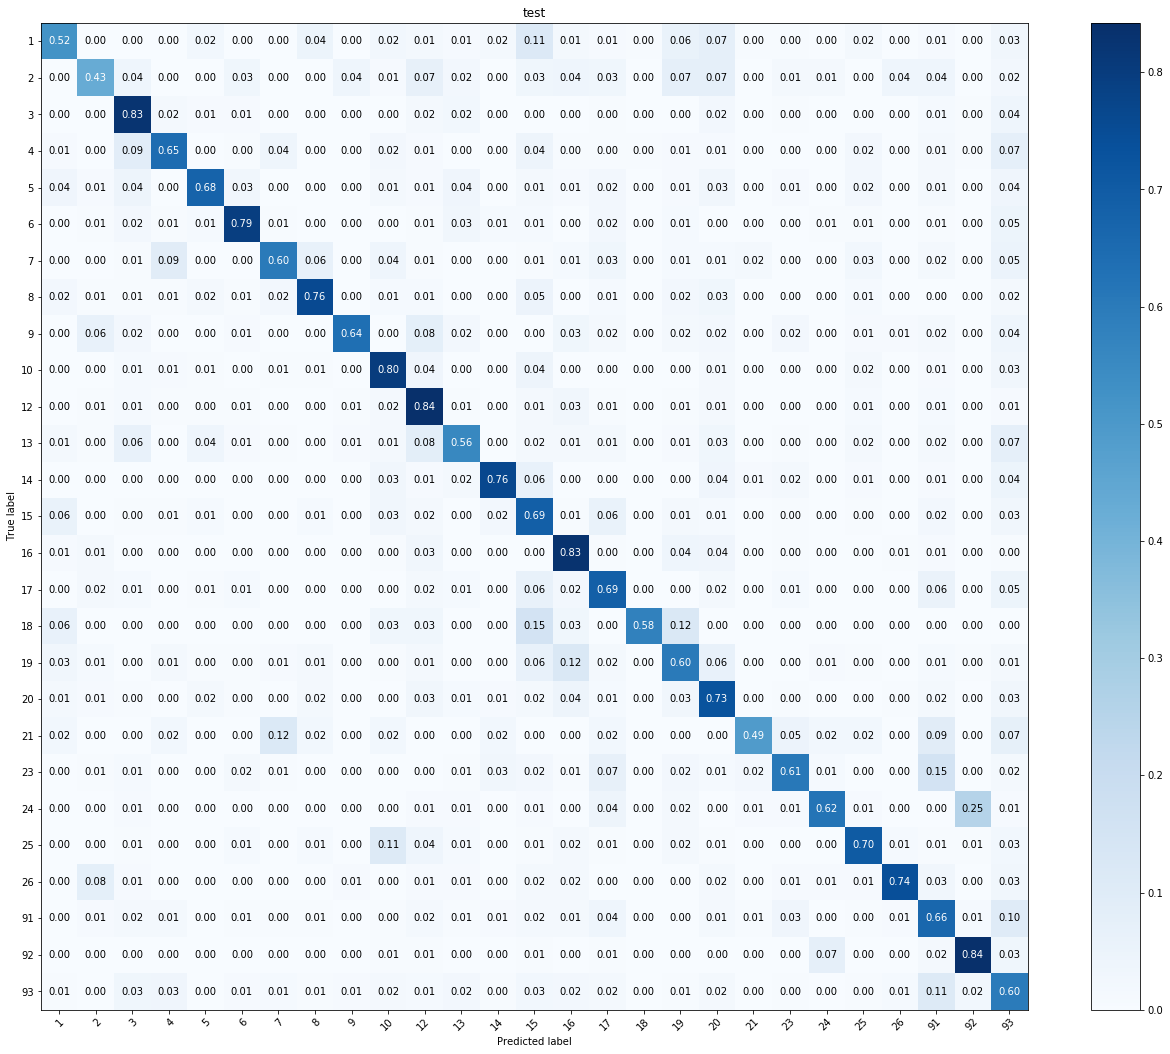

In [13]:
testy = u.plot_cf(validation_y, result_data['5_0.5_0.65']['validation_preds'], title = 'test')

In [56]:
sampled_indexes, data_pool, test_preds = basic_wrapper(scaler=0.65, threshold=0.9, iterations=1, sample_size=False, num_ensembles=5, sample_rate=0.5)

Iteration: 1
Total number of unlabeled added: 304878
Ensemble iteration 1
{19: 426, 12: 1194, 5: 213, 3: 660, 20: 676, 26: 156, 10: 507, 93: 938, 2: 203, 4: 332, 92: 492, 25: 236, 1: 308, 13: 322, 15: 722, 16: 720, 9: 198, 91: 856, 17: 491, 8: 281, 23: 285, 6: 261, 14: 172, 24: 177, 7: 237, 21: 64, 18: 50}
Ensemble iteration 2
{19: 426, 12: 1194, 5: 213, 3: 660, 20: 676, 26: 156, 10: 507, 93: 938, 2: 203, 4: 332, 92: 492, 25: 236, 1: 308, 13: 322, 15: 722, 16: 720, 9: 198, 91: 856, 17: 491, 8: 281, 23: 285, 6: 261, 14: 172, 24: 177, 7: 237, 21: 64, 18: 50}
Ensemble iteration 3
{19: 426, 12: 1194, 5: 213, 3: 660, 20: 676, 26: 156, 10: 507, 93: 938, 2: 203, 4: 332, 92: 492, 25: 236, 1: 308, 13: 322, 15: 722, 16: 720, 9: 198, 91: 856, 17: 491, 8: 281, 23: 285, 6: 261, 14: 172, 24: 177, 7: 237, 21: 64, 18: 50}
Ensemble iteration 4
{19: 426, 12: 1194, 5: 213, 3: 660, 20: 676, 26: 156, 10: 507, 93: 938, 2: 203, 4: 332, 92: 492, 25: 236, 1: 308, 13: 322, 15: 722, 16: 720, 9: 198, 91: 856, 17:

In [58]:
np.mean(test_y == test_preds)

0.7121008854306413

In [59]:
data_pool['y'].value_counts()

12    49389
3     27459
16    26755
10    23339
20    20349
15    15541
6     15255
17    14066
8     12516
4     12128
25     9578
23     7903
9      7758
19     7621
13     7425
14     6874
5      6830
1      6796
7      6769
24     5471
26     4954
93     3454
2      2643
91     1759
92     1163
18      578
21      505
dtype: int64

In [ ]:
train_y.value_counts()

In [ ]:
class SoftlabelSamplerEnsembleClassifier(BaseEstimator, ClassifierMixin):

    def __init__(self, conf_X, conf_y, vec, vec_params, clf, clf_params, num_ensembles=10, sample_rate=0.2):
        
        self.conf_X = conf_X
        self.conf_y = conf_y
        self.vec = vec
        self.vec_params = vec_params
        self.clf = clf
        self.clf_params = clf_params
        self.num_ensembles = num_ensembles
        self.sample_rate = sample_rate

    def fit(self, X, y):

        self.classes_ = y.unique()
        self.X_ = X
        self.y_ = y
        self.vecs_ = []
        self.clfs_ = []
        
        for i in range(self.num_ensembles):
            
            print("Fit iteration: " + str(i+1))
            
            set_index = pd.Index([])

            for c in self.classes_:

                num_samples = int(sum(y == c) * self.sample_rate)
                #num_samples = int(sum(y == c) * self.sample_rate[i % 5])
                num_samples = min(num_samples, sum(self.conf_y == c))

                label_index = (self.conf_y == c).sample(n=num_samples, random_state=i).index
                set_index = set_index.union(label_index)
            
            i_X = self.X_.append(self.conf_X.loc[set_index])
            i_y = self.y_.append(self.conf_y.loc[set_index])
            
            self.vecs_.append(self.vec(**self.vec_params))
            vec_i_X = self.vecs_[i].fit_transform(i_X)

            self.clfs_.append(self.clf(**self.clf_params))
            self.clfs_[i].fit(vec_i_X, i_y)
        
        return self

    def predict(self, X):
        
        ensemble_preds = np.zeros((X.shape[0], self.num_ensembles))
        
        for i in range(self.num_ensembles):
            
            print("Predict iteration: " + str(i+1))
            
            vec_X = self.vecs_[i].transform(X)
            ensemble_preds[:, i] = self.clfs_[i].predict(vec_X)
            
        mode_ensemble_preds = stats.mode(ensemble_preds, axis=1)
    
        return mode_ensemble_preds[0].T[0]